In [211]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

In [212]:
# Path to ./data/processed folder
path_data_processed = os.path.join(
    os.path.abspath('../'),
    'data',
    'processed'
)

# Load Data

In [213]:
df_stocks = pd.read_csv(
    os.path.join(
        path_data_processed,
        'stock_market_dataset.csv'
    ),
    index_col=0
)

df_stocks = df_stocks.pivot_table(
    values='Close',
    index='Date',
    columns='Stock'
).reset_index(drop=False)

In [214]:
df_agg = pd.read_csv(
    os.path.join(
        path_data_processed,
        'reddit_news_avg_score_per_label.csv'
    )
)

In [215]:
df = df_stocks.merge(df_agg, on='Date', how='left')

stocks = ['AAPL'] # , 'AMZN', 'GOOGL', 'MSFT', 'NVDA'
for stock in stocks:
    df[f'{stock}_target'] = df[stock].shift(1)

In [216]:
# df = df_stocks[['Date', 'AAPL']]
# df['AAPL_target'] = df['AAPL'].shift(1)

In [217]:
df

,Date,AAPL,AMZN,GOOGL,MSFT,NVDA,negative,neutral,positive,AAPL_target
0,2008-06-09,23.257,79.43,278.94,23.238,21.978,0.800000,0.995000,NaN,NaN
1,2008-06-10,23.774,79.62,277.08,23.389,20.680,0.915000,0.983684,NaN,23.257
2,2008-06-11,23.156,77.28,272.60,22.744,19.714,0.915000,0.941905,1.000000,23.774
3,2008-06-12,22.189,76.15,276.48,23.682,19.837,0.816667,0.929000,0.930000,23.156
4,2008-06-13,22.074,79.17,285.76,24.377,19.771,0.985000,0.990000,0.500000,22.189
...,...,...,...,...,...,...,...,...,...,...
2027,2016-06-27,89.635,691.36,681.14,46.998,44.945,0.880000,0.972143,0.892500,90.960
2028,2016-06-28,91.145,707.95,691.26,47.978,45.592,0.980000,0.971765,0.810000,89.635
2029,2016-06-29,91.934,715.46,695.19,49.045,46.315,0.937500,0.959412,0.990000,91.145
2030,2016-06-30,93.102,715.62,703.53,49.657,46.705,0.940000,0.976667,0.986667,91.934


# Data Preparation

In [218]:
# Select features
data = df.drop([
    'Date',
    'AMZN', 'GOOGL', 'MSFT', 'NVDA'
    ], axis=1)

data['positive'] = data['positive'].fillna(0)
data['negative'] = data['negative'].fillna(0)

data = data.dropna()

In [219]:
data

,AAPL,negative,neutral,positive,AAPL_target
1,23.774,0.915000,0.983684,0.000000,23.257
2,23.156,0.915000,0.941905,1.000000,23.774
3,22.189,0.816667,0.929000,0.930000,23.156
4,22.074,0.985000,0.990000,0.500000,22.189
5,22.647,0.956667,0.984286,1.000000,22.074
...,...,...,...,...,...
2027,89.635,0.880000,0.972143,0.892500,90.960
2028,91.145,0.980000,0.971765,0.810000,89.635
2029,91.934,0.937500,0.959412,0.990000,91.145
2030,93.102,0.940000,0.976667,0.986667,91.934


## Train-Test Split

In [220]:
# Set train percentage
train_percentage = 0.95

# Compute lenght of train dataframe
train_len = int(len(data) * train_percentage)

In [221]:
# Create data_train and data_test:
df_train = data.iloc[:train_len]
df_test = data.iloc[train_len:]

In [222]:
data.columns

Index(['AAPL', 'negative', 'neutral', 'positive', 'AAPL_target'], dtype='object')

In [223]:
data.head()

,AAPL,negative,neutral,positive,AAPL_target
1,23.774,0.915000,0.983684,0.00,23.257
2,23.156,0.915000,0.941905,1.00,23.774
3,22.189,0.816667,0.929000,0.93,23.156
4,22.074,0.985000,0.990000,0.50,22.189
5,22.647,0.956667,0.984286,1.00,22.074


<Axes: xlabel='AAPL_target'>

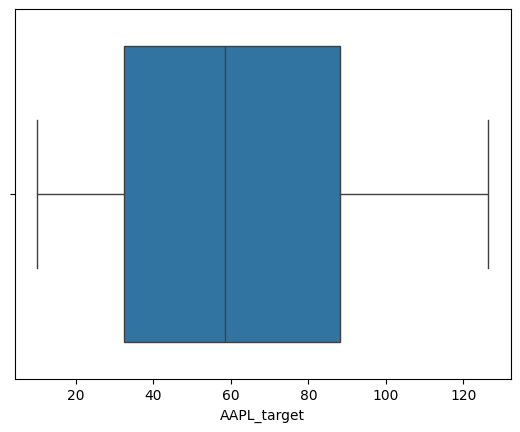

In [224]:
sns.boxplot(data=data, x='AAPL_target')

In [225]:
data.describe()

,AAPL,negative,neutral,positive,AAPL_target
count,2031.000000,2031.000000,2031.000000,2031.000000,2031.000000
mean,61.174153,0.882724,0.967181,0.786513,61.139624
std,32.671985,0.106661,0.021234,0.351331,32.674984
min,10.014000,0.000000,0.865333,0.000000,10.014000
25%,32.386500,0.848375,0.955000,0.810000,32.341500
50%,58.475000,0.898000,0.970435,0.960000,58.459000
75%,88.171500,0.945000,0.983170,0.996667,88.128500
max,126.490000,1.000000,1.000000,1.000000,126.490000


In [226]:
data.isnull().sum()

AAPL           0
negative       0
neutral        0
positive       0
AAPL_target    0
dtype: int64

## Scaling
Transforming numerical features into a common smaller range

In [227]:
features_scale = [
    'AAPL',
    # 'AMZN',
    # 'GOOGL',
    # 'MSFT',
    # 'NVDA',
    # 'negative',
    # 'neutral',
    # 'positive'
]

target = [
    'AAPL_target',
    # 'AMZN_target',
    # 'GOOGL_target',
    # 'MSFT_target',
    # 'NVDA_target'
]

target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features_scale])
df_train[features_scale] = features_scaler.transform(df_train[features_scale])
df_test[features_scale] = features_scaler.transform(df_test[features_scale])

/tmp/ipykernel_2047/1299088375.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target] = target_scaler.transform(df_train[target])
/tmp/ipykernel_2047/1299088375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target] = target_scaler.transform(df_test[target])
/tmp/ipykernel_2047/1299088375.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

## Subsequences

In [228]:
# Create subsequence with 5 business days X 4 weeks X 3 months
length = 5 * 4 * 3
horizon = 1
window = 1

### One Subsequence

In [229]:
def subsequence(df, length, features, target):
    X, y = [], []

    for i in range(length, df.shape[0]):
        X.append(df[features].iloc[i - length: i]) #  + target
        y.append(df[target].iloc[i])

    X = np.array(X)
    y = np.expand_dims(
        np.array(y).astype(np.float32),
        axis=-1
    )

    return X, y

In [230]:
features = [
    'AAPL',
    # 'AMZN',
    # 'GOOGL',
    # 'MSFT',
    # 'NVDA',
    'negative',
    'neutral',
    'positive'
]

X_train, y_train = subsequence(df_train, length, features, target)

X_test, y_test = subsequence(df_test, length, features, target)

In [231]:
y_train.shape

(1869, 1, 1)

In [232]:
X_train.shape

(1869, 60, 4)

# RNN Model

In [233]:
# Padding train and test
X_train_pad = pad_sequences(X_train, value=-999, padding='post', dtype='float64')
X_test_pad = pad_sequences(X_test, value=-999, padding='post', dtype='float64')

In [234]:
# Build the model
def rnn_model():
    model = Sequential()

    model.add(layers.Masking(mask_value=-999))

    model.add(
        layers.LSTM(
            units=128,
            return_sequences = True,
            activation = "tanh",
            input_shape = X_train_pad[0].shape
        )
    )

    model.add(
        layers.LSTM(
            units=64,
            return_sequences = False,
            activation = "tanh"
        )
    )

    model.add(layers.Dense(25, activation="relu"))

    model.add(layers.Dense(1, activation="relu"))

    my_mae = metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

    model.compile(
        loss="mse",
        optimizer = "rmsprop",
        metrics = [my_mae]
    )

    return model

model = rnn_model()

/home/nathalia/.pyenv/versions/3.10.6/envs/stocks_vs_behavior/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [235]:
%%time

es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")

history = model.fit(
    X_train_pad,
    np.array(y_train),
    validation_split = 0.3,
    batch_size=16,
    epochs=300,
    verbose = 1,
    callbacks = [es]
)

Epoch 1/300


82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - loss: 0.0383 - mean_absolute_error: 0.1253 - val_loss: 0.0675 - val_mean_absolute_error: 0.2530
Epoch 2/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.0043 - mean_absolute_error: 0.0546 - val_loss: 0.0317 - val_mean_absolute_error: 0.1695
Epoch 3/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - loss: 0.0023 - mean_absolute_error: 0.0382 - val_loss: 0.0138 - val_mean_absolute_error: 0.1056
Epoch 4/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - loss: 0.0019 - mean_absolute_error: 0.0334 - val_loss: 0.0045 - val_mean_absolute_error: 0.0539
Epoch 5/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.0013 - mean_absolute_error: 0.0283 - val_loss: 0.0016 - val_mean_absolute_error: 0.0342
Epoch 6/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - loss: 0.0012 - mean_absolute_error: 0.0284 - val_loss: 0.0138 - val_mean_absolute_error: 0.1086
Epoch 7/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - loss: 0.0010 - mean_absolute_error: 0.0245 -

In [236]:
for i in history.history.keys():
    value = np.mean(history.history[i])
    print(i, " = ", value)

loss  =  0.0003197022231010944
mean_absolute_error  =  0.011406867367708507
val_loss  =  0.0015135079456918973
val_mean_absolute_error  =  0.024329778930062756


In [237]:
from sklearn.metrics import r2_score

In [238]:
def plot_loss_mae(history):

    fig, ax =plt.subplots(1,2,figsize=(20,5))

    # --- LOSS

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    plt.show()

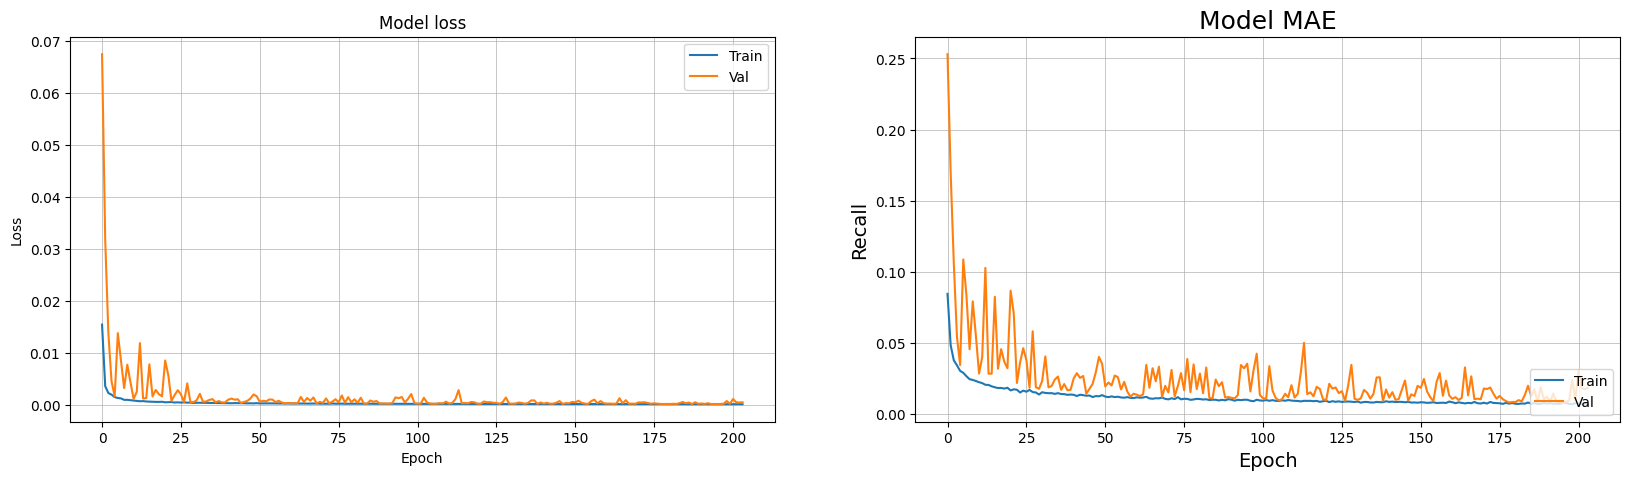

In [239]:
plot_loss_mae(history)

In [240]:
X_train_pad.shape

(1869, 60, 4)

In [241]:
np.array(y_train).shape

(1869, 1, 1)

In [243]:
y_pred = target_scaler.inverse_transform(model.predict(X_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step


In [244]:
y_test2 = y_test[:, 0, 0]

In [248]:
y_pred.shape

(42, 1)

In [252]:
y_test2

array([0.7050208 , 0.6967959 , 0.6936193 , 0.68925786, 0.68985885,
       0.69512177, 0.687515  , 0.66936535, 0.6708678 , 0.69896805,
       0.69570553, 0.7046602 , 0.7016295 , 0.71017206, 0.72027713,
       0.7325801 , 0.7467976 , 0.75357157, 0.7530736 , 0.74896973,
       0.73725057, 0.7310777 , 0.7327432 , 0.73869294, 0.7420241 ,
       0.7412686 , 0.7472097 , 0.74044436, 0.72789246, 0.7289055 ,
       0.72622687, 0.7296439 , 0.7110907 , 0.7091761 , 0.7159415 ,
       0.7130138 , 0.7175298 , 0.6949586 , 0.6835829 , 0.6965469 ,
       0.70332086, 0.7133487 ], dtype=float32)

In [253]:
r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test))
r2

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


0.49322080612182617

In [ ]:
len(y_pred)

42

In [ ]:
tmp = df_test.copy()
tmp['target'] = target_scaler.inverse_transform(tmp[['AAPL_target']])

In [ ]:
X_test.shape

(42, 60, 4)

In [ ]:
y_pred

array([[10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014],
       [10.014]], dtype=float32)

In [ ]:
y_real - y_pred

array([[82.11800006],
       [81.16000006],
       [80.79000006],
       [80.28200006],
       [80.35200006],
       [80.96500006],
       [80.07900006],
       [77.96500006],
       [78.14000006],
       [81.41300006],
       [81.03300006],
       [82.07600006],
       [81.72300006],
       [82.71800006],
       [83.89500006],
       [85.32800006],
       [86.98400006],
       [87.77300006],
       [87.71500006],
       [87.23700006],
       [85.87200006],
       [85.15300006],
       [85.34700006],
       [86.04000006],
       [86.42800006],
       [86.34000006],
       [87.03200006],
       [86.24400006],
       [84.78200006],
       [84.90000006],
       [84.58800006],
       [84.98600006],
       [82.82500006],
       [82.60200006],
       [83.39000006],
       [83.04900006],
       [83.57500006],
       [80.94600006],
       [79.62100006],
       [81.13100006],
       [81.92000006],
       [83.08800006]])

In [ ]:
df_diff = pd.concat([
    pd.DataFrame(y_real, columns=['Real']),
    pd.DataFrame(y_pred, columns=['Pred'])
], axis=1
)

df_diff['Next_Real'] = df_diff['Real'].shift(-1)
df_diff['Next_Pred'] = df_diff['Pred'].shift(-1)

df_diff['Diff_real'] = df_diff['Real'] - df_diff['Next_Real']
df_diff['Diff_pred'] = df_diff['Pred'] - df_diff['Next_Pred']

In [ ]:
df_diff

,Real,Pred,Next_Real,Next_Pred,Diff_real,Diff_pred
0,92.132,10.014,91.174,10.014,0.958,0.0
1,91.174,10.014,90.804,10.014,0.370,0.0
2,90.804,10.014,90.296,10.014,0.508,0.0
3,90.296,10.014,90.366,10.014,-0.070,0.0
4,90.366,10.014,90.979,10.014,-0.613,0.0
5,90.979,10.014,90.093,10.014,0.886,0.0
6,90.093,10.014,87.979,10.014,2.114,0.0
7,87.979,10.014,88.154,10.014,-0.175,0.0
8,88.154,10.014,91.427,10.014,-3.273,0.0
9,91.427,10.014,91.047,10.014,0.380,0.0
